In [1]:
import pandas as pd
import numpy as np

# Load ChEMBL splits
chembl_train = pd.read_csv('datasets/chembl_pretraining_train.csv')
chembl_val = pd.read_csv('datasets/chembl_pretraining_val.csv')
chembl_test = pd.read_csv('datasets/chembl_pretraining_test.csv')

protein_cols = [c for c in chembl_train.columns if c != 'smiles']

# Get proteins with data in each split
coverage = {}
for split, df in [('train', chembl_train), ('val', chembl_val), ('test', chembl_test)]:
    has_data = df[protein_cols].notna().sum() > 0
    coverage[split] = set([p for p in protein_cols if has_data[p]])

# Find missing proteins in each split
missing = {}
for split in ['train', 'val', 'test']:
    missing[split] = set(protein_cols) - coverage[split]

# Proteins missing everywhere (should be removed from dataset)
never_covered = missing['train'] & missing['val'] & missing['test']

# Proteins missing in only some splits
missing_train_only = missing['train'] - never_covered
missing_val_only = missing['val'] - never_covered
missing_test_only = missing['test'] - never_covered
missing_val_test = (missing['val'] & missing['test']) - never_covered
missing_train_val = (missing['train'] & missing['val']) - never_covered
missing_train_test = (missing['train'] & missing['test']) - never_covered

print("=== PROTEIN COVERAGE ANALYSIS ===")
print(f"Total proteins: {len(protein_cols)}")
print(f"\nProteins with coverage:")
print(f"  Train: {len(coverage['train'])}/{len(protein_cols)} ({100*len(coverage['train'])/len(protein_cols):.1f}%)")
print(f"  Val:   {len(coverage['val'])}/{len(protein_cols)} ({100*len(coverage['val'])/len(protein_cols):.1f}%)")
print(f"  Test:  {len(coverage['test'])}/{len(protein_cols)} ({100*len(coverage['test'])/len(protein_cols):.1f}%)")

print(f"\n=== PROTEINS TO REMOVE (no data in any split) ===")
if never_covered:
    print(f"Found {len(never_covered)} proteins with no data anywhere:")
    for p in sorted(never_covered):
        print(f"  - {p}")
else:
    print("All proteins have data in at least one split")

print(f"\n=== PROBLEMATIC PROTEIN DISTRIBUTIONS ===")
if missing_val_test:
    print(f"\nProteins ONLY in train (missing in val AND test): {len(missing_val_test)}")
    for p in sorted(missing_val_test)[:10]:
        print(f"  - {p}")
    if len(missing_val_test) > 10:
        print(f"  ... and {len(missing_val_test)-10} more")

if missing_train_only:
    print(f"\nProteins missing ONLY in train: {len(missing_train_only)}")
    for p in sorted(missing_train_only)[:5]:
        print(f"  - {p}")

if missing_val_only:
    print(f"\nProteins missing ONLY in val: {len(missing_val_only)}")
    for p in sorted(missing_val_only)[:5]:
        print(f"  - {p}")

if missing_test_only:
    print(f"\nProteins missing ONLY in test: {len(missing_test_only)}")
    for p in sorted(missing_test_only)[:5]:
        print(f"  - {p}")

# Count measurements per protein per split
print("\n=== MEASUREMENT DISTRIBUTION ===")
measurements = {}
for split, df in [('train', chembl_train), ('val', chembl_val), ('test', chembl_test)]:
    measurements[split] = df[protein_cols].notna().sum()

# Find proteins with very few measurements
sparse_proteins = []
for p in protein_cols:
    total = sum(measurements[s][p] for s in ['train', 'val', 'test'])
    if total > 0 and total < 10:
        sparse_proteins.append((p, total, measurements['train'][p], measurements['val'][p], measurements['test'][p]))

if sparse_proteins:
    print("\nProteins with < 10 total measurements (train/val/test):")
    sparse_proteins.sort(key=lambda x: x[1])
    for p, total, tr, va, te in sparse_proteins[:10]:
        print(f"  {p}: {total} total ({tr}/{va}/{te})")

# Check PKIS2 files existence
print("\n=== PKIS2 FILE CHECK ===")
import os
for split in ['train', 'val', 'test']:
    fname = f'datasets/pkis2_finetuning_{split}.csv'
    if os.path.exists(fname):
        df = pd.read_csv(fname)
        print(f"{fname}: {len(df)} molecules")
    else:
        print(f"{fname}: FILE NOT FOUND!")

=== PROTEIN COVERAGE ANALYSIS ===
Total proteins: 342

Proteins with coverage:
  Train: 335/342 (98.0%)
  Val:   331/342 (96.8%)
  Test:  316/342 (92.4%)

=== PROTEINS TO REMOVE (no data in any split) ===
All proteins have data in at least one split

=== PROBLEMATIC PROTEIN DISTRIBUTIONS ===

Proteins ONLY in train (missing in val AND test): 1
  - ERK4

Proteins missing ONLY in train: 7
  - CTK
  - LOK
  - MYO3A
  - NDR2
  - TESK1

Proteins missing ONLY in val: 11
  - BRSK2
  - DCAMKL1
  - ERK4
  - LOK
  - MAP3K1

Proteins missing ONLY in test: 26
  - ANKK1
  - CASK
  - CDC2L2
  - CDK11
  - CDKL1

=== MEASUREMENT DISTRIBUTION ===

Proteins with < 10 total measurements (train/val/test):
  CDKL1: 2 total (1/1/0)
  CTK: 2 total (0/1/1)
  DCAMKL1: 2 total (1/0/1)
  ERK4: 2 total (2/0/0)
  LOK: 2 total (0/0/2)
  MAP3K3: 2 total (1/0/1)
  MYO3A: 2 total (0/1/1)
  NDR2: 2 total (0/1/1)
  NEK7: 2 total (1/1/0)
  NIM1: 2 total (1/0/1)

=== PKIS2 FILE CHECK ===
datasets/pkis2_finetuning_train.cs

Analyzing split quality...

INTRA-DATASET OVERLAPS (should be 0):
  ✓ pretrain_murcko: No overlaps
  ✗ pretrain_generic: {'train-val': 1013, 'train-test': 1018, 'val-test': 752}
  ✓ finetune_murcko: No overlaps
  ✗ finetune_generic: {'train-val': 25, 'train-test': 20, 'val-test': 17}

CROSS-DATASET OVERLAPS:
  murcko_train: 271 molecules (89.1%)
  murcko_val: 68 molecules (43.6%)
  murcko_test: 69 molecules (37.3%)
  generic_train: 287 molecules (94.4%)
  generic_val: 115 molecules (73.7%)
  generic_test: 106 molecules (57.3%)

Plotting analysis...


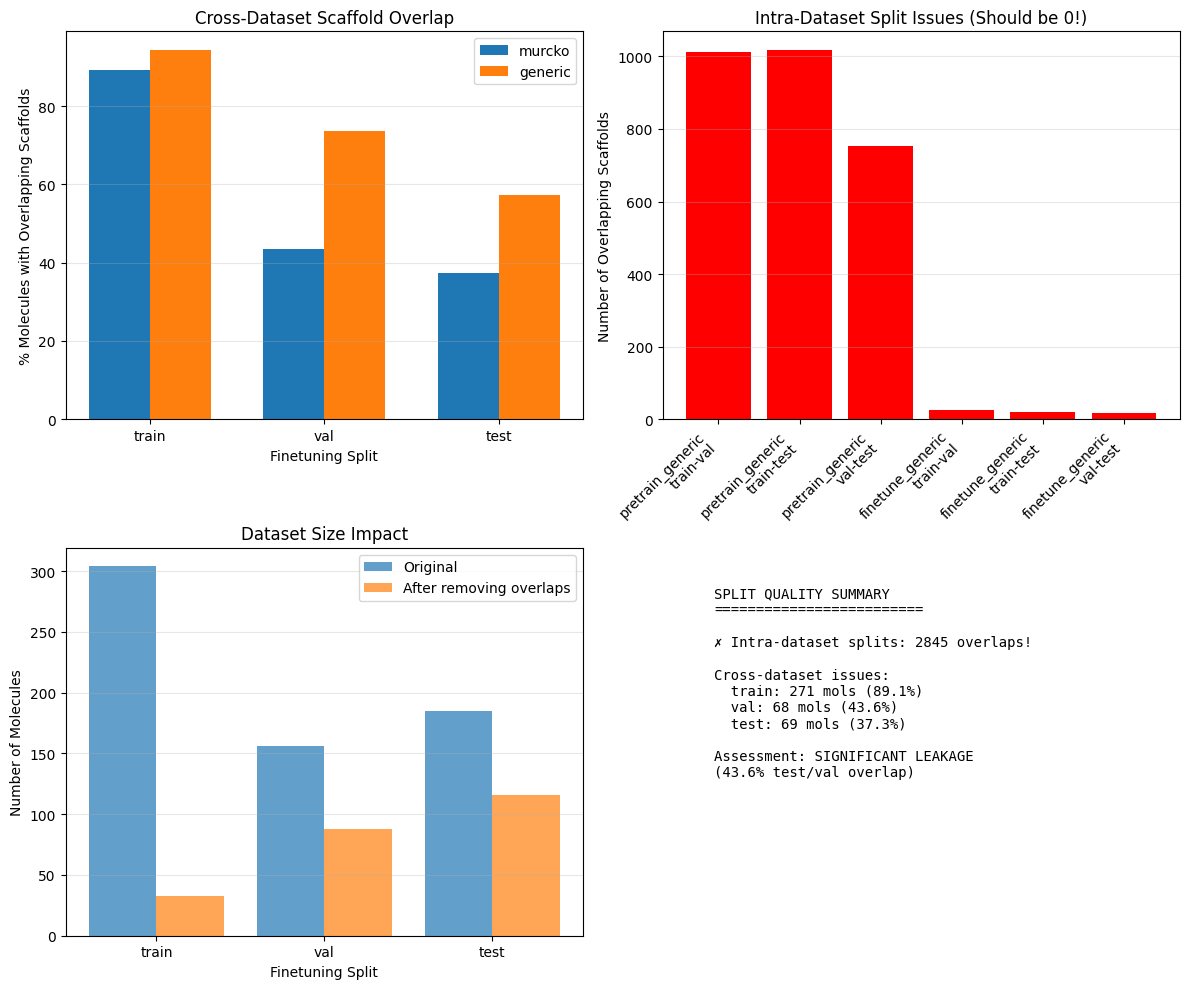

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import matplotlib.pyplot as plt
import numpy as np

def get_scaffold(smiles, level='murcko'):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if level == 'generic':
        scaffold = MurckoScaffold.MakeScaffoldGeneric(scaffold)
    return Chem.MolToSmiles(scaffold)

def analyze_splits(pretrain_data, finetune_data):
    results = {
        'intra_dataset_overlap': {},
        'cross_dataset_overlap': {},
        'scaffold_sharing': {}
    }
    
    # Check intra-dataset splits (should be 0 if splits done correctly)
    for dataset_name, dataset in [('pretrain', pretrain_data), ('finetune', finetune_data)]:
        for level in ['murcko', 'generic']:
            scaffolds = {split: set(dataset[split]['smiles'].apply(lambda x: get_scaffold(x, level)).dropna()) 
                        for split in dataset}
            
            overlaps = {
                'train-val': len(scaffolds['train'] & scaffolds['val']),
                'train-test': len(scaffolds['train'] & scaffolds['test']),
                'val-test': len(scaffolds['val'] & scaffolds['test'])
            }
            results['intra_dataset_overlap'][f'{dataset_name}_{level}'] = overlaps
    
    # Cross-dataset analysis
    for level in ['murcko', 'generic']:
        pretrain_all = set()
        for split in pretrain_data:
            pretrain_all |= set(pretrain_data[split]['smiles'].apply(lambda x: get_scaffold(x, level)).dropna())
        
        for split in finetune_data:
            finetune_scaffolds = finetune_data[split]['smiles'].apply(lambda x: get_scaffold(x, level)).dropna()
            overlapping = finetune_scaffolds.isin(pretrain_all)
            
            results['cross_dataset_overlap'][f'{level}_{split}'] = {
                'n_molecules_overlapping': overlapping.sum(),
                'pct_molecules_overlapping': (overlapping.sum() / len(finetune_scaffolds) * 100),
                'n_unique_scaffolds_overlapping': len(set(finetune_scaffolds[overlapping]))
            }
    
    # Scaffold frequency analysis
    all_scaffolds = []
    for dataset in [pretrain_data, finetune_data]:
        for split in dataset:
            scaffolds = dataset[split]['smiles'].apply(lambda x: get_scaffold(x, 'murcko')).dropna()
            all_scaffolds.extend(scaffolds)
    
    scaffold_counts = pd.Series(all_scaffolds).value_counts()
    results['scaffold_sharing']['most_frequent'] = scaffold_counts.head(10).to_dict()
    results['scaffold_sharing']['n_shared_btw_datasets'] = (scaffold_counts > 1).sum()
    
    return results

def plot_analysis(results, pretrain_data, finetune_data):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Cross-dataset overlap percentages
    ax = axes[0, 0]
    levels = ['murcko', 'generic']
    splits = ['train', 'val', 'test']
    x = np.arange(len(splits))
    width = 0.35
    
    for i, level in enumerate(levels):
        pcts = [results['cross_dataset_overlap'][f'{level}_{split}']['pct_molecules_overlapping'] 
                for split in splits]
        ax.bar(x + i*width, pcts, width, label=level)
    
    ax.set_xlabel('Finetuning Split')
    ax.set_ylabel('% Molecules with Overlapping Scaffolds')
    ax.set_title('Cross-Dataset Scaffold Overlap')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(splits)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Intra-dataset overlaps (quality check)
    ax = axes[0, 1]
    intra_issues = []
    labels = []
    for dataset_level, overlaps in results['intra_dataset_overlap'].items():
        for pair, count in overlaps.items():
            if count > 0:
                intra_issues.append(count)
                labels.append(f'{dataset_level}\n{pair}')
    
    if intra_issues:
        ax.bar(range(len(intra_issues)), intra_issues, color='red')
        ax.set_xticks(range(len(intra_issues)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_ylabel('Number of Overlapping Scaffolds')
        ax.set_title('Intra-Dataset Split Issues (Should be 0!)')
    else:
        ax.text(0.5, 0.5, 'No intra-dataset overlaps\n(Splits done correctly)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Intra-Dataset Split Check')
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 3: Dataset sizes impact
    ax = axes[1, 0]
    original_sizes = {split: len(finetune_data[split]) for split in splits}
    remaining_pcts = {split: 100 - results['cross_dataset_overlap'][f'murcko_{split}']['pct_molecules_overlapping'] 
                     for split in splits}
    
    x = np.arange(len(splits))
    ax.bar(x - 0.2, list(original_sizes.values()), 0.4, label='Original', alpha=0.7)
    ax.bar(x + 0.2, [original_sizes[s] * remaining_pcts[s]/100 for s in splits], 
           0.4, label='After removing overlaps', alpha=0.7)
    
    ax.set_xlabel('Finetuning Split')
    ax.set_ylabel('Number of Molecules')
    ax.set_title('Dataset Size Impact')
    ax.set_xticks(x)
    ax.set_xticklabels(splits)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 4: Overlap summary statistics
    ax = axes[1, 1]
    summary_text = "SPLIT QUALITY SUMMARY\n" + "="*25 + "\n\n"
    
    # Check if splits were done correctly
    intra_problems = sum(sum(v.values()) for v in results['intra_dataset_overlap'].values())
    if intra_problems == 0:
        summary_text += "✓ Intra-dataset splits: CORRECT\n"
    else:
        summary_text += f"✗ Intra-dataset splits: {intra_problems} overlaps!\n"
    
    summary_text += "\nCross-dataset issues:\n"
    for split in splits:
        pct = results['cross_dataset_overlap'][f'murcko_{split}']['pct_molecules_overlapping']
        n_mols = results['cross_dataset_overlap'][f'murcko_{split}']['n_molecules_overlapping']
        summary_text += f"  {split}: {n_mols} mols ({pct:.1f}%)\n"
    
    worst_case = max(results['cross_dataset_overlap'][f'murcko_{s}']['pct_molecules_overlapping'] 
                    for s in ['val', 'test'])
    
    if worst_case > 50:
        summary_text += f"\nAssessment: SEVERE LEAKAGE\n({worst_case:.1f}% test/val overlap)"
    elif worst_case > 25:
        summary_text += f"\nAssessment: SIGNIFICANT LEAKAGE\n({worst_case:.1f}% test/val overlap)"
    else:
        summary_text += f"\nAssessment: MODERATE LEAKAGE\n({worst_case:.1f}% test/val overlap)"
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', family='monospace')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('split_quality_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# Load datasets
pretrain_data = {
    'train': pd.read_csv('datasets/chembl_pretraining_train.csv'),
    'val': pd.read_csv('datasets/chembl_pretraining_val.csv'),
    'test': pd.read_csv('datasets/chembl_pretraining_test.csv')
}

finetune_data = {
    'train': pd.read_csv('datasets/pkis2_finetuning_train.csv'),
    'val': pd.read_csv('datasets/pkis2_finetuning_val.csv'),
    'test': pd.read_csv('datasets/pkis2_finetuning_test.csv')
}

print("Analyzing split quality...\n")
results = analyze_splits(pretrain_data, finetune_data)

# Print summary
print("INTRA-DATASET OVERLAPS (should be 0):")
for dataset_level, overlaps in results['intra_dataset_overlap'].items():
    if any(v > 0 for v in overlaps.values()):
        print(f"  ✗ {dataset_level}: {overlaps}")
    else:
        print(f"  ✓ {dataset_level}: No overlaps")

print("\nCROSS-DATASET OVERLAPS:")
for key, stats in results['cross_dataset_overlap'].items():
    print(f"  {key}: {stats['n_molecules_overlapping']} molecules ({stats['pct_molecules_overlapping']:.1f}%)")

print("\nPlotting analysis...")
plot_analysis(results, pretrain_data, finetune_data)
